# Modeling

In [6]:
import os
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [7]:
print(tf.__version__)

2.15.0


In [8]:
print(tf.config.experimental.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset preparation

In [9]:
photo_path = os.path.realpath('/kaggle/input/inaturalist-photos/photos')

I first tried using an `image_size` of 150x150, then increased it to 300x300 to increase prediction accuracy.

In [10]:
image_size = 300

In [11]:
animal_classes = ['alces_alces', 'sciurus_carolinensis', 'ursus_americanus',
       'homo_sapiens', 'odocoileus_virginianus', 'peromyscus_maniculatus',
       'erethizon_dorsatum', 'vulpes_vulpes', 'blarina_brevicauda',
       'canis_lycaon', 'castor_canadensis', 'neogale_vison',
       'canis_latrans', 'lontra_canadensis', 'tamias_striatus',
       'canis_familiaris', 'ondatra_zibethicus', 'mephitis_mephitis',
       'tamiasciurus_hudsonicus', 'lynx_rufus', 'procyon_lotor',
       'felis_catus', 'marmota_monax', 'sylvilagus_floridanus',
       'lepus_americanus', 'didelphis_virginiana', 'pekania_pennanti',
       'peromyscus', 'canidae', 'urocyon_cinereoargenteus',
       'rattus_norvegicus', 'microtus_pennsylvanicus', 'martes_americana',
       'carnivora', 'parascalops_breweri', 'eptesicus_fuscus',
       'mustela_richardsonii', 'condylura_cristata', 'rodentia',
       'sciuridae', 'leporidae', 'placentalia', 'vespertilionidae']

We load the data an keep 10% for validation.

In [12]:
ds_train, ds_valid = image_dataset_from_directory(  
    directory= photo_path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(image_size, image_size),
    class_names=animal_classes,
    shuffle=True,
    seed=42,
    validation_split=0.1,
    subset='both',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=True,
)


Found 47580 files belonging to 43 classes.
Using 42822 files for training.
Using 4758 files for validation.


Let's take a look at a few picture (one batch of 32).

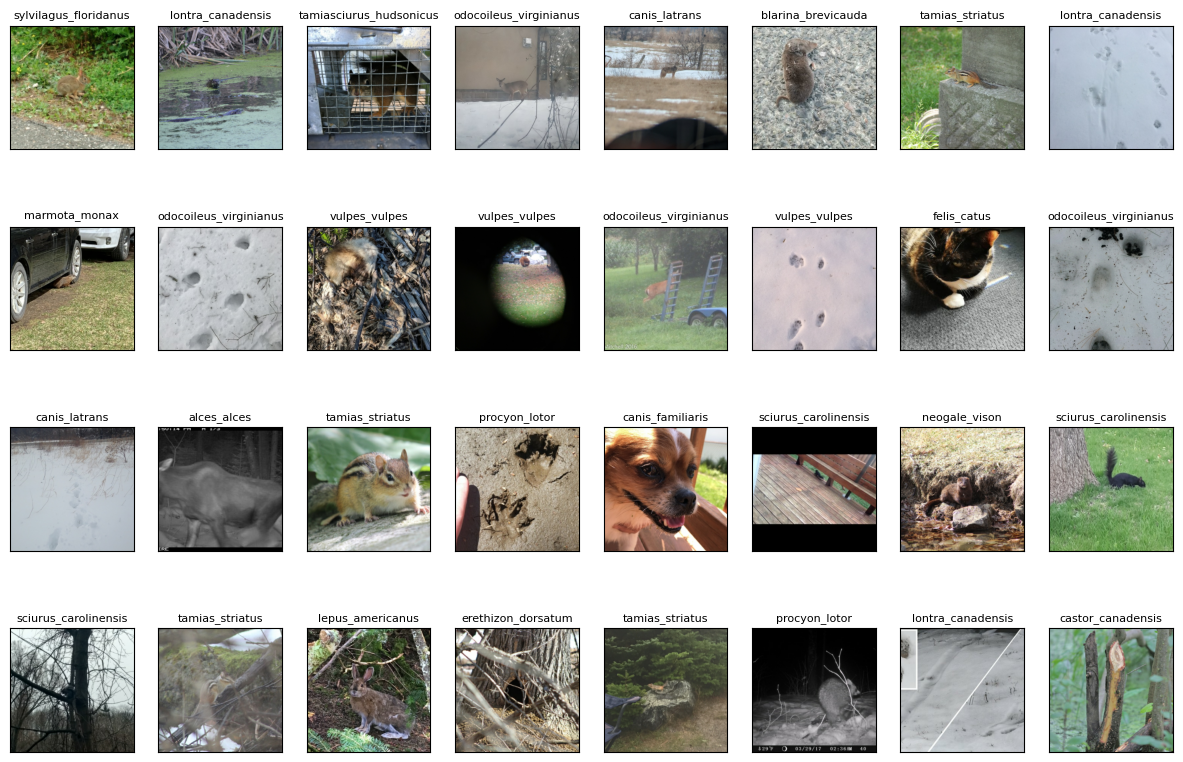

In [13]:
plt.figure(figsize=(15, 10))
for image, label in ds_train.take(1):
    for i in range (32):
        ax = plt.subplot(4, 8, i + 1)
        ax.imshow(image[i].numpy().astype("uint8"))
        ax.set_title(animal_classes[label[i]], size=8)
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])

We see that most pictures are pictures of animals. However, some are pictures of tracks, scatts of other types of animal observations. This will probably impact the model's prediction perfomance, as we don't have that many images that are not pictures of animals (and no easy way to classify animals, tracks, etc. as we don't have such labels).

## Data Augmentation

We will use data augmentation as the first step of our model.

In [14]:
augmentation = keras.Sequential([
    layers.RandomBrightness(0.2, [0.0, 255.0]),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(0.1),
])

Let's look at a few generated augmented images from the same initial image.

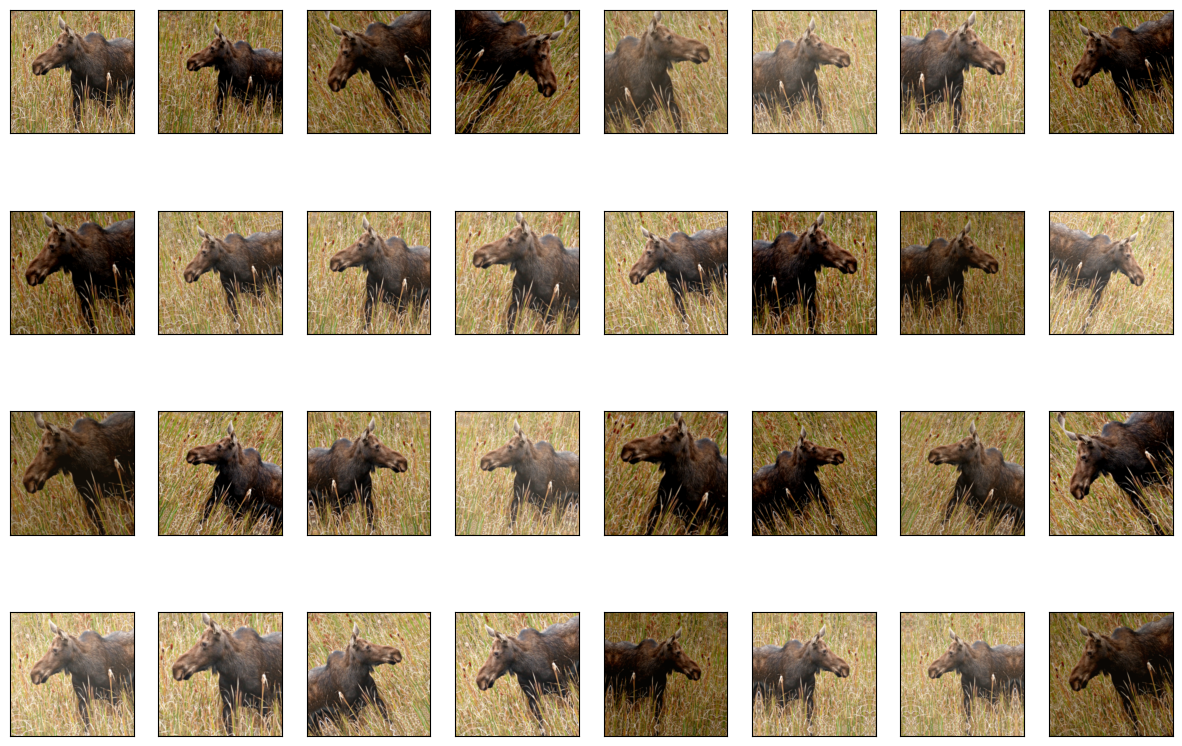

In [15]:
plt.figure(figsize=(15, 10))
for image, label in ds_train.take(1):
    ax = plt.subplot(4, 8, 1)
    ax.imshow(image[1,:].numpy().astype("uint8"))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    for i in range (31):
        ax = plt.subplot(4, 8, i + 2)
        ax.imshow(augmentation(image[1,:]).numpy().astype("uint8"))
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])

## CNN Model

We'll start by training a simple CNN model with 4 conv layers.

In [35]:
model_1 = keras.Sequential([
    layers.Input((image_size, image_size, 3)),
    augmentation,
    layers.Rescaling(1/255),

    layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    layers.MaxPool2D(2),
    
    layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPool2D(2),
    
    layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    layers.MaxPool2D(2),
    
    layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    layers.MaxPool2D(2),
    
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(43, activation='softmax')
])


In [36]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=1E-4)
model_1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (300, 300, 3)             0         
                                                                 
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 149, 149, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                 

In [37]:
history_1 = model_1.fit(ds_train, validation_data=ds_valid, epochs=50, callbacks=[early_stopping])

Epoch 1/50
1339/1339 [==============================] - 97s 71ms/step - loss: 3.1195 - accuracy: 0.1560 - val_loss: 2.9866 - val_accuracy: 0.1927
Epoch 2/50
1339/1339 [==============================] - 95s 71ms/step - loss: 2.9612 - accuracy: 0.1935 - val_loss: 2.8603 - val_accuracy: 0.2194
Epoch 3/50
1339/1339 [==============================] - 95s 70ms/step - loss: 2.8705 - accuracy: 0.2138 - val_loss: 2.8111 - val_accuracy: 0.2240
Epoch 4/50
1339/1339 [==============================] - 95s 71ms/step - loss: 2.8050 - accuracy: 0.2305 - val_loss: 2.7576 - val_accuracy: 0.2423
Epoch 5/50
1339/1339 [==============================] - 95s 71ms/step - loss: 2.7572 - accuracy: 0.2466 - val_loss: 2.7033 - val_accuracy: 0.2625
Epoch 6/50
1339/1339 [==============================] - 95s 71ms/step - loss: 2.7029 - accuracy: 0.2613 - val_loss: 2.6467 - val_accuracy: 0.2778
Epoch 7/50
1339/1339 [==============================] - 95s 70ms/step - loss: 2.6718 - accuracy: 0.2731 - val_loss: 2.6309 -

In [22]:
 def plot_history(history, title):
    fig, axs = plt.subplots(1, 2, figsize = (15,5))
    axs[0].plot(history.history['loss'], label = 'training')
    axs[0].plot(history.history['val_loss'], label = 'validation')
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])

    axs[0].legend()
    axs[0].set_xlim(0)
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('Loss')

    axs[1].set_xlim(0)
    axs[1].set_ylim(0,1)
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('Accuracy')
    
    fig.suptitle(title);

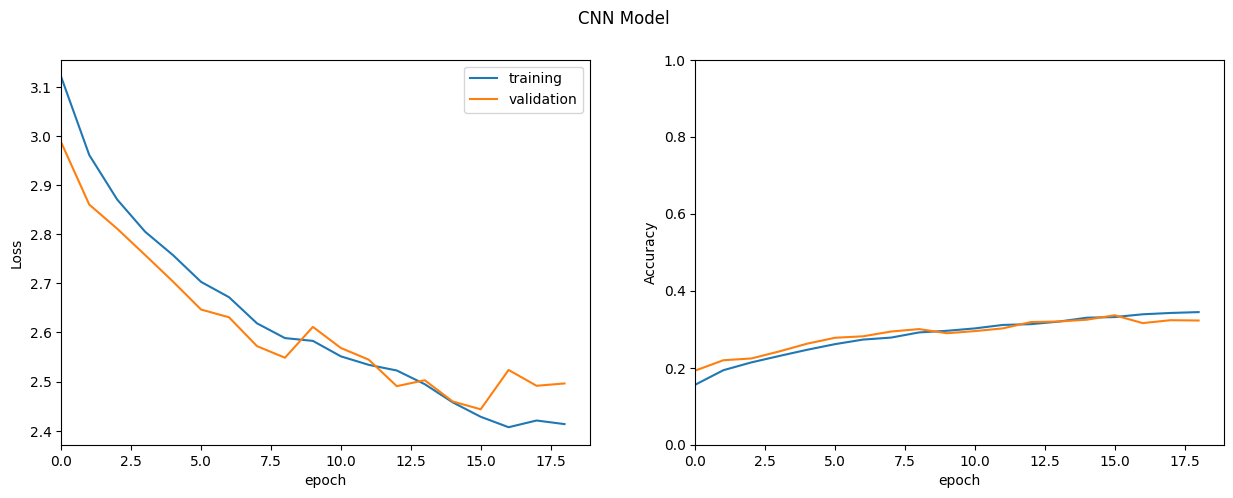

In [52]:
plot_history(history_1, 'CNN Model')

In [53]:
model_1.save_weights('/kaggle/working/models/CNN_300.weights.h5')

In [ ]:
model_1.load_weights('/kaggle/working/models/CNN_300.weights.h5')

After trying different model architectures, 30% accuracy on the validation test is about the highest we can get. We will try using a pretrained network to improve accuracy.

# Pretrained Model

We'll reuse `EfficientNetV2B0` pretrained on `imagenet` and build a custom top layers for our classification task. 

### Training the top layers

We first load the pretrained model as the second step of our model (first one is data augmentation)

In [16]:
EfficientNetV2B0 = keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(image_size, image_size, 3),
    pooling=None,
)

24274472/24274472 [==============================] - 0s 0us/step


We freeze it so that only the dense head will be trained during the first training stage

In [17]:
EfficientNetV2B0.trainable = False

In [18]:
inputs = keras.Input((image_size, image_size, 3))
x = augmentation(inputs)
x = EfficientNetV2B0(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)
outputs = layers.Dense(43, activation='softmax')(x)

pretrained = keras.Model(inputs, outputs)

pretrained.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 10, 10, 1280)      5919312   N          
 nal)                                                                       
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0         Y          
                                                                            
 dense (Dense)               (None, 512)               655872

In [19]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=1E-3)
pretrained.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
history_pretrained = pretrained.fit(ds_train, validation_data=ds_valid, epochs=20, callbacks=[early_stopping])

Epoch 1/20


I0000 00:00:1710685897.132668     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1339/1339 [==============================] - 185s 127ms/step - loss: 1.7933 - accuracy: 0.5272 - val_loss: 1.3004 - val_accuracy: 0.6351
Epoch 2/20
1339/1339 [==============================] - 92s 68ms/step - loss: 1.4189 - accuracy: 0.6105 - val_loss: 1.2117 - val_accuracy: 0.6572
Epoch 3/20
1339/1339 [==============================] - 92s 69ms/step - loss: 1.3203 - accuracy: 0.6341 - val_loss: 1.1714 - val_accuracy: 0.6662
Epoch 4/20
1339/1339 [==============================] - 92s 69ms/step - loss: 1.2465 - accuracy: 0.6511 - val_loss: 1.1490 - val_accuracy: 0.6774
Epoch 5/20
1339/1339 [==============================] - 92s 69ms/step - loss: 1.2036 - accuracy: 0.6625 - val_loss: 1.1076 - val_accuracy: 0.6898
Epoch 6/20
1339/1339 [==============================] - 93s 69ms/step - loss: 1.1564 - accuracy: 0.6769 - val_loss: 1.0921 - val_accuracy: 0.6955
Epoch 7/20
1339/1339 [==============================] - 92s 69ms/step - loss: 1.1142 - accuracy: 0.6856 - val_loss: 1.0689 - val_accu

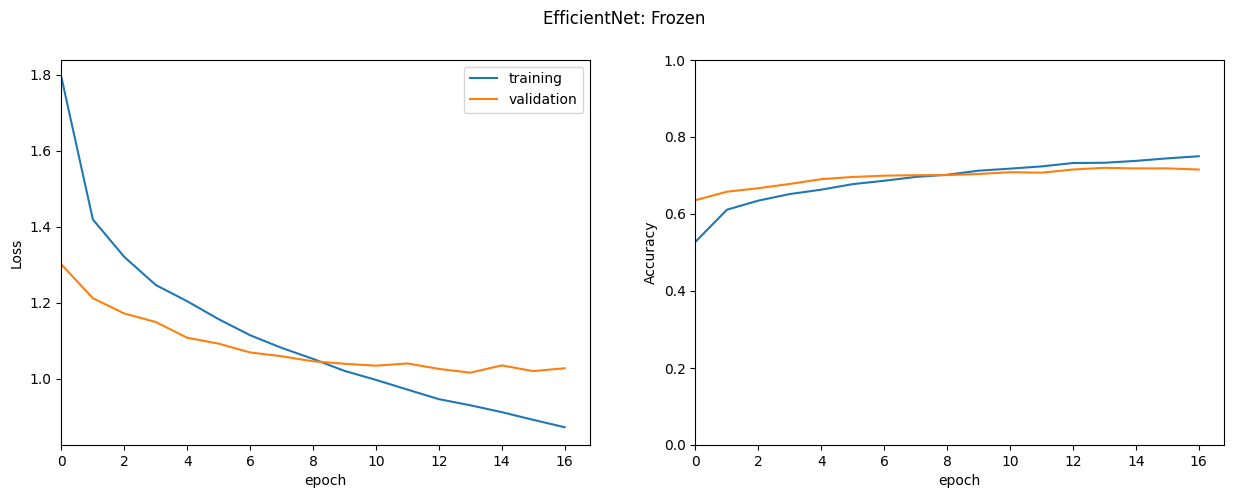

In [25]:
plot_history(history_pretrained, 'EfficientNet: Frozen')

With a bit more than 10 training rounds, the pretrained model's accuracy is more than twice that of the CNN model we've trained before.

In [26]:
pretrained.save_weights('/kaggle/working/models/pretrained_top_300_ratio.weights.h5')

### Fine tuning

We now unfreeze the bottom layer and fine tune the model using a reduced learning rate.

In [27]:
EfficientNetV2B0.trainable = True
optimizer = keras.optimizers.Adam(learning_rate=1E-5) #learning rate reduce by a factor of 10
pretrained.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pretrained.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 10, 10, 1280)      5919312   Y          
 nal)                                                                       
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0         Y          
                                                                            
 dense (Dense)               (None, 512)               655872

In [28]:
history_pretrained_fine = pretrained.fit(ds_train, validation_data=ds_valid, epochs=30, callbacks=[early_stopping])

Epoch 1/30
1339/1339 [==============================] - 321s 204ms/step - loss: 0.8363 - accuracy: 0.7610 - val_loss: 0.9503 - val_accuracy: 0.7303
Epoch 2/30
1339/1339 [==============================] - 275s 205ms/step - loss: 0.7812 - accuracy: 0.7757 - val_loss: 0.9331 - val_accuracy: 0.7394
Epoch 3/30
 508/1339 [==========>...................] - ETA: 2:44 - loss: 0.7607 - accuracy: 0.7820

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1339/1339 [==============================] - 275s 205ms/step - loss: 0.7474 - accuracy: 0.7846 - val_loss: 0.9303 - val_accuracy: 0.7377
Epoch 4/30
1339/1339 [==============================] - 274s 204ms/step - loss: 0.7198 - accuracy: 0.7935 - val_loss: 0.9159 - val_accuracy: 0.7427
Epoch 5/30
1339/1339 [==============================] - 270s 201ms/step - loss: 0.6899 - accuracy: 0.8027 - val_loss: 0.9246 - val_accuracy: 0.7421
Epoch 6/30
1339/1339 [==============================] - 274s 204ms/step - loss: 0.6683 - accuracy: 0.8096 - val_loss: 0.9084 - val_accuracy: 0.7442
Epoch 7/30
1339/1339 [==============================] - 274s 204ms/step - loss: 0.6464 - accuracy: 0.8183 - val_loss: 0.9098 - val_accuracy: 0.7484
Epoch 8/30
1339/1339 [==============================] - 274s 204ms/step - loss: 0.6247 - accuracy: 0.8238 - val_loss: 0.9078 - val_accuracy: 0.7509
Epoch 9/30
1339/1339 [==============================] - 274s 204ms/step - loss: 0.6024 - accuracy: 0.8300 - val_loss: 0.903

In [30]:
pretrained.save_weights('/kaggle/working/models/pretrained_fine_300_ratio.weights.h5')

In [31]:
pretrained.save('/kaggle/working/models/pretrained_fine_300_ratio')

In [32]:
#pretrained.load_weights('/kaggle/working/models/pretrained_fine_300_ratio.weights.h5')

In [34]:
predictions = pretrained.predict(ds_valid)
prediction_class = np.argmax(predictions, axis=1)
list_valid = list(ds_valid.unbatch())

149/149 [==============================] - 12s 65ms/step


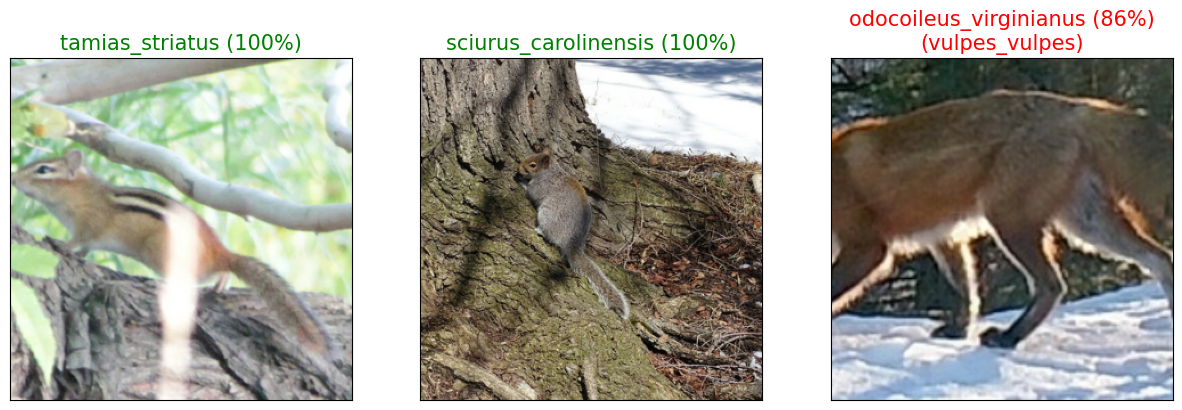

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(15,20))
                      
for i in range(3):
    n = np.random.randint(0, len(predictions))
    image, label = list_valid[n]
    axs[i].imshow(image.numpy().astype("uint8"))
    if prediction_class[n] == label:
        axs[i].set_title(animal_classes[prediction_class[n]] + f' ({round(np.max(predictions[n])*100)}%)', size=15, color='green')
    else:
        axs[i].set_title(animal_classes[prediction_class[n]] + f' ({round(np.max(predictions[n])*100)}%)' + f'\n({animal_classes[label]})', size=15, color='red')
    axs[i].axes.xaxis.set_ticks([])
    axs[i].axes.yaxis.set_ticks([])